In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1.1

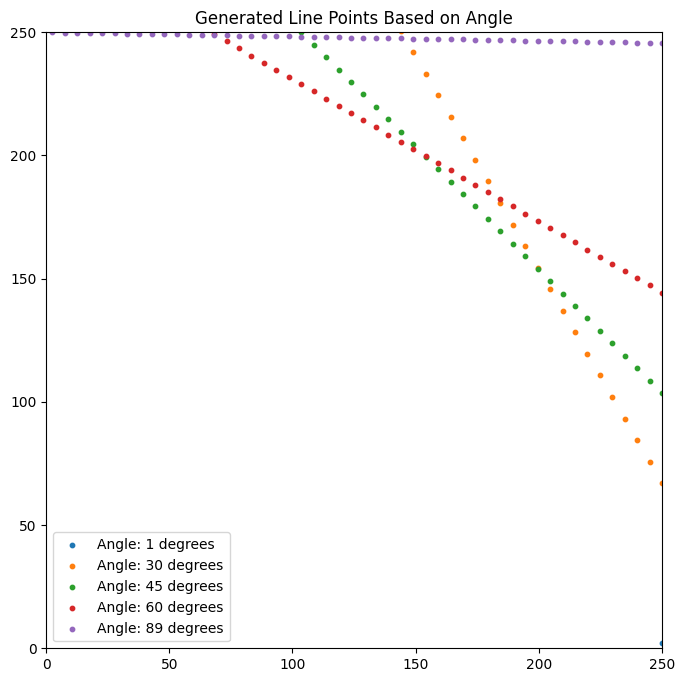

In [9]:
# 1.1

def generateLinePoints(angle, dist_from_origin):
    angle = np.radians(angle)

    # compute normal vector (cosine and sine of angle)
    nx = np.cos(angle)
    ny = np.sin(angle)

    # line equation: nx * x + ny * y = distance from origin
    x = np.linspace(-dist_from_origin, dist_from_origin, num=100)
    y = (dist_from_origin - nx * x) / ny
    return x, y

test_angles = [1, 30, 45, 60, 89]
dist = 250
plt.figure(figsize=(10, 8))
for angle in test_angles:
    x, y = generateLinePoints(angle, dist)
    plt.scatter(x, y, label=f"Angle: {angle} degrees", s=10)
plt.legend()
plt.title("Generated Line Points Based on Angle")
plt.xlim(0, dist)
plt.ylim(0, dist)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


# 1.2

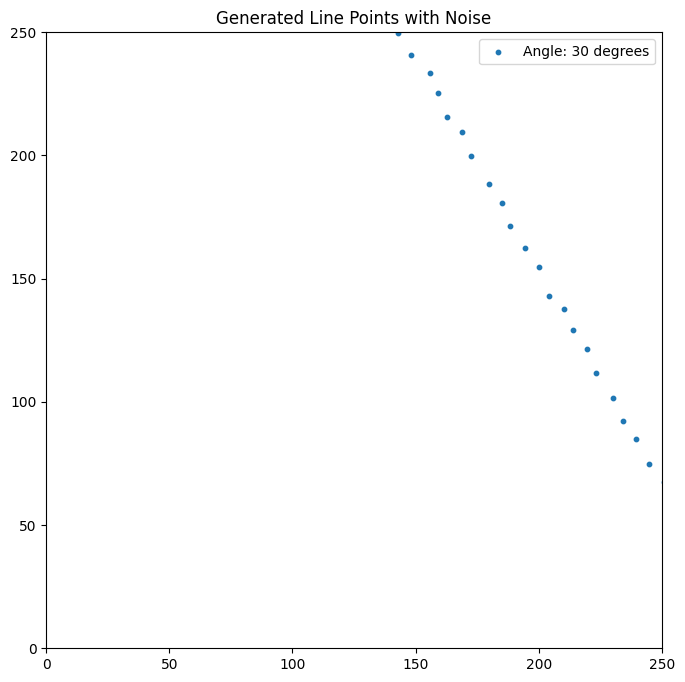

In [22]:
# 1.2

def addGaussianNoise(x, y, mean, std):
    noise_x = np.random.normal(mean, std, x.shape)
    noise_y = np.random.normal(mean, std, y.shape)
    return x + noise_x, y + noise_y

# add noise to a given line
angle = 30
x, y = generateLinePoints(angle, dist)
x_noisy, y_noisy = addGaussianNoise(x, y, 0, 1)

# plot
plt.figure(figsize=(10, 8))
plt.scatter(x_noisy, y_noisy, label=f"Angle: {angle} degrees", s=10)
plt.legend()
plt.title("Generated Line Points with Noise")
plt.xlim(0, dist)
plt.ylim(0, dist)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# 1.3

In [26]:
# 1.3

def estimateParameters(points):
    points = np.array(points)

    # (vx, vy) is normalized direction vector of line
    # (x0, y0) is a point on the line
    line = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)

    vx, vy, x0, y0 = line[0], line[1], line[2], line[3]

    # Calculate the angle from the direction vector (vx, vy)
    angle_rad = np.arctan2(vy, vx)  # Use arctan2 to get the correct quadrant
    angle_deg = np.degrees(angle_rad)  # Convert to degrees
    
    # Calculate the perpendicular distance from the origin to the line
    distance_from_origin = np.abs(x0 * vy - y0 * vx)
    
    return 90 + angle_deg[0], distance_from_origin[0]

# estimate param of the noisy data:
points = np.vstack([x_noisy, y_noisy]).T
params = estimateParameters(points)

print("Noisy Line Parameters: ")
print("Estimated degree: ", params[0])
print("Estimated distance: ", params[1])
print(f"Degree Error: {abs(angle - params[0]): .3f}, Distance Error: {abs(dist - params[1]): .3f}")


Noisy Line Parameters: 
Estimated degree:  29.985698699951172
Estimated distance:  249.86401
Degree Error:  0.014, Distance Error:  0.136


# 1.4

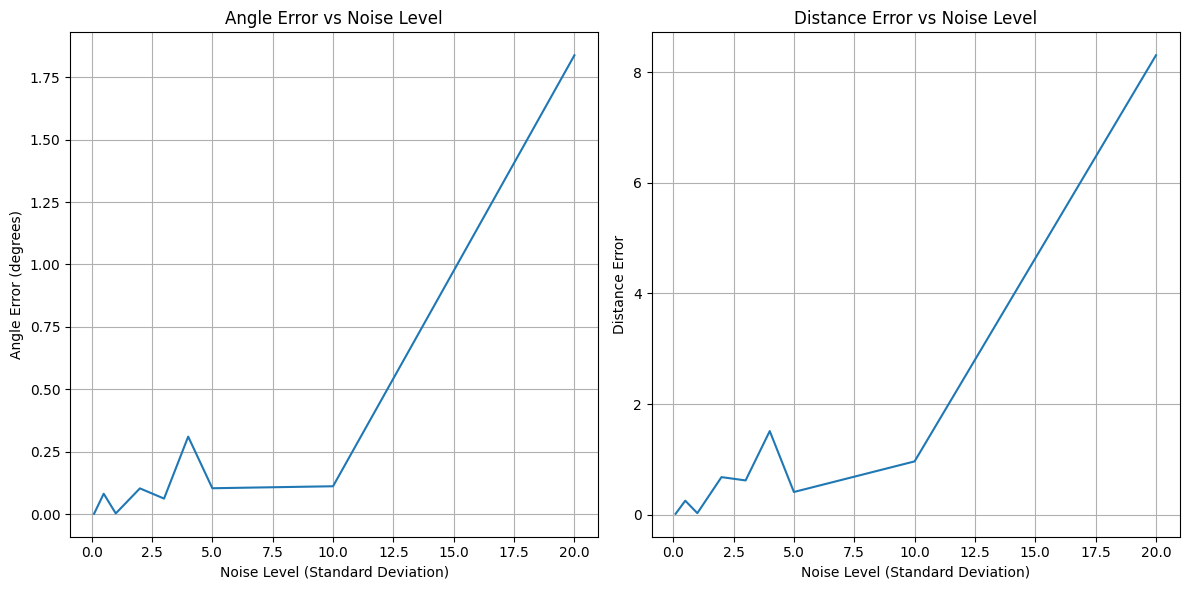

In [30]:
# 1.4

noise_levels = [0.1, 0.5, 1, 2, 3, 4, 5, 10, 20]

angle_errors = []
distance_errors = []

known_angle = 30
known_distance = 100
x, y = generateLinePoints(angle=known_angle, dist_from_origin=known_distance)

# calculate error for each noise
for noise in noise_levels:
    x_noisy, y_noisy = addGaussianNoise(x, y, mean=0, std=noise)
    points = np.vstack([x_noisy, y_noisy]).T
    estimated_angle, estimated_distance = estimateParameters(points)
    angle_error = np.abs(known_angle - estimated_angle)
    distance_error = np.abs(known_distance - estimated_distance)

    # record error
    angle_errors.append(angle_error)
    distance_errors.append(distance_error)

# print(angle_errors)
# print(distance_errors)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(noise_levels, angle_errors, label="Angle Error")
plt.xlabel("Noise Level (Standard Deviation)")
plt.ylabel("Angle Error (degrees)")
plt.title("Angle Error vs Noise Level")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, distance_errors, label="Distance Error")
plt.xlabel("Noise Level (Standard Deviation)")
plt.ylabel("Distance Error")
plt.title("Distance Error vs Noise Level")
plt.grid(True)

plt.tight_layout()
plt.show()


# 1.5

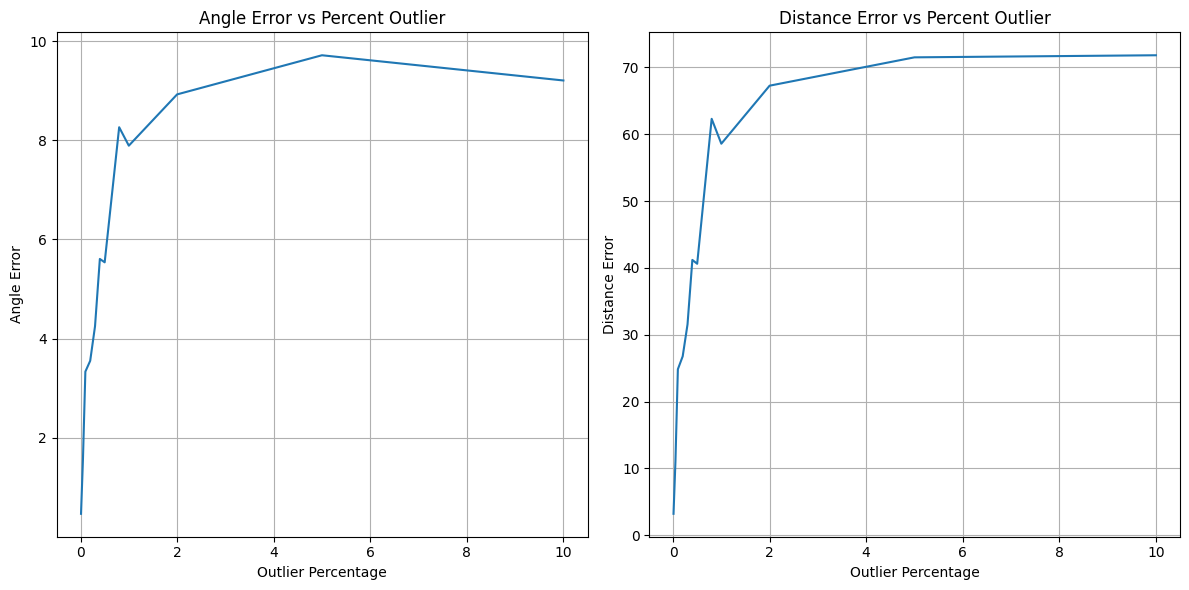

In [37]:
# 1.5

def addOutliers(x, y, distance, outlier_percentage):
    num_points = len(x)
    num_outliers = int(outlier_percentage * num_points)

    # generage random outliers
    outlier_x = np.random.uniform(0, distance, num_outliers)
    outlier_y = np.random.uniform(0, distance, num_outliers)

    x_with_outliers = np.concatenate([x, outlier_x])
    y_with_outliers = np.concatenate([y, outlier_y])

    return x_with_outliers, y_with_outliers


known_angle = 45
known_distance = 250
x, y = generateLinePoints(angle=known_angle, dist_from_origin=known_distance)
x_with_outliers, y_with_outliers = addOutliers(x, y, known_distance, 0.1)


# calculate error for each outlier percentage
angle_errors = []
distance_errors = []

percentages = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 2, 5, 10]
for percentage in percentages:
    x_with_outliers, y_with_outliers = addOutliers(x, y, known_distance, outlier_percentage=percentage)
    points = np.vstack([x_with_outliers, y_with_outliers]).T
    estimated_angle, estimated_distance = estimateParameters(points)
    angle_error = np.abs(known_angle - estimated_angle)
    distance_error = np.abs(known_distance - estimated_distance)

    # record error
    angle_errors.append(angle_error)
    distance_errors.append(distance_error)

# display error from outlier percentage
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(percentages, angle_errors, label="Angle Error")
plt.xlabel("Outlier Percentage")
plt.ylabel("Angle Error")
plt.title("Angle Error vs Percent Outlier")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(percentages, distance_errors, label="Distance Error")
plt.xlabel("Outlier Percentage")
plt.ylabel("Distance Error")
plt.title("Distance Error vs Percent Outlier")
plt.grid(True)

plt.tight_layout()
plt.show()

# 1.6

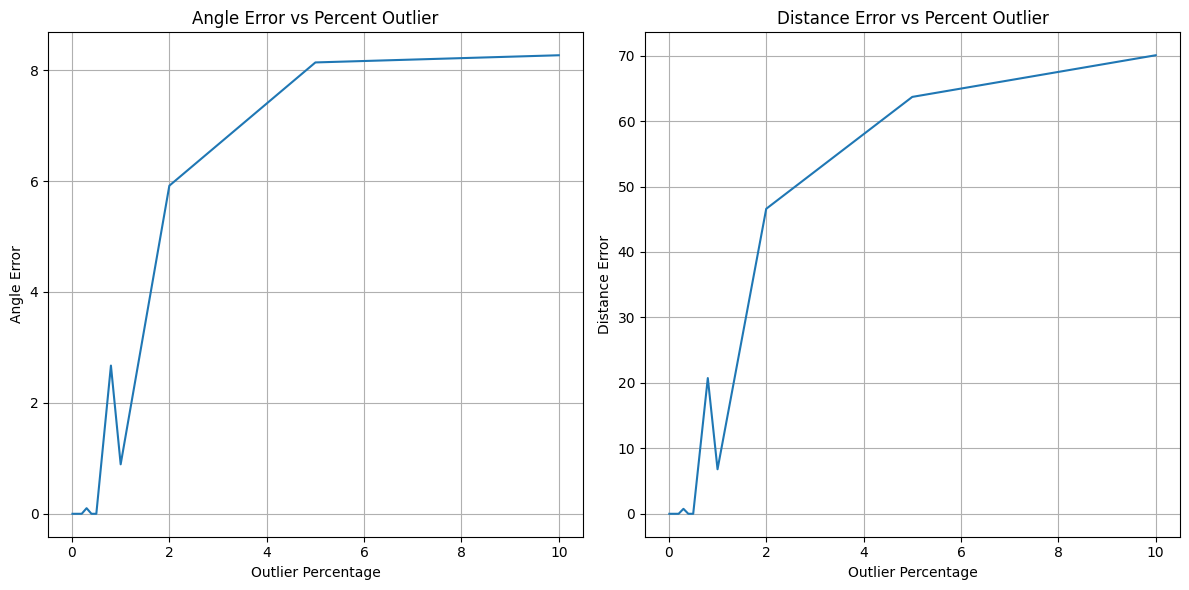

In [38]:
# 1.6

def estimateParametersWithHuber(points):
    points = np.array(points)

    # (vx, vy) is normalized direction vector of line
    # (x0, y0) is a point on the line
    line = cv2.fitLine(points, cv2.DIST_HUBER, 0, 0.01, 0.01)

    vx, vy, x0, y0 = line[0], line[1], line[2], line[3]

    # Calculate the angle from the direction vector (vx, vy)
    angle_rad = np.arctan2(vy, vx)  # Use arctan2 to get the correct quadrant
    angle_deg = np.degrees(angle_rad)  # Convert to degrees
    
    # Calculate the perpendicular distance from the origin to the line
    distance_from_origin = np.abs(x0 * vy - y0 * vx)
    
    return 90 + angle_deg[0], distance_from_origin[0]

known_angle = 45
known_distance = 250
x, y = generateLinePoints(angle=known_angle, dist_from_origin=known_distance)
x_with_outliers, y_with_outliers = addOutliers(x, y, known_distance, 0.1)


angle_errors = []
distance_errors = []

# redo problem 1.5, but using points estimated with huber
percentages = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 2, 5, 10]
for percentage in percentages:
    x_with_outliers, y_with_outliers = addOutliers(x, y, known_distance, outlier_percentage=percentage)
    points = np.vstack([x_with_outliers, y_with_outliers]).T
    estimated_angle, estimated_distance = estimateParametersWithHuber(points)
    angle_error = np.abs(known_angle - estimated_angle)
    distance_error = np.abs(known_distance - estimated_distance)

    # record error
    angle_errors.append(angle_error)
    distance_errors.append(distance_error)


# display error from outlier percentage
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(percentages, angle_errors, label="Angle Error")
plt.xlabel("Outlier Percentage")
plt.ylabel("Angle Error")
plt.title("Angle Error vs Percent Outlier")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(percentages, distance_errors, label="Distance Error")
plt.xlabel("Outlier Percentage")
plt.ylabel("Distance Error")
plt.title("Distance Error vs Percent Outlier")
plt.grid(True)

plt.tight_layout()
plt.show()

1.7

Based on the results above, the error from percentage of outlier is smaller when doing line estimation using the CV_HIST_HUBER distance compared to CV_DIST_L2 distance. We see in both that as the percentage of outlier increases, so does the angle error and the distance error.